In [2]:
from immuno_ms2rescore_tools.file_utilities import PrositLib
import pandas as pd
import numpy as np
import xgboost as xgb
from math import sqrt
from math import acos
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from math import acos
import pickle

In [3]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)

In [4]:
with open("data/training_data/training_upeps.pkl", "rb") as f:
    train_ovp = pickle.load(f)
train_ovp = list(train_ovp.astype(str))

# Correlation functions

In [12]:
def ms2pip_pearson(true, pred):
    """
    Return pearson of tic-normalized, log-transformed intensities, 
    the MS2PIP way.
    """
    #tic_norm = lambda x: x / np.sum(x)
    # log_transform = lambda x: np.log2(x + 0.001)
    corr = pearsonr(
        true, 
        pred
    )[0]
    return (corr)

In [13]:
def spectral_angle(true, pred, epsilon=1e-7):
    """
    Return square root normalized spectral angle.
    See https://doi.org/10.1074/mcp.O113.036475
    """
    true = np.array(true)
    pred = np.array(pred)
    
    de_log = lambda x: (2**x)-0.001
    l2_normalize = lambda x: x / sqrt(max(sum(x**2), epsilon))
    
    pred_norm = l2_normalize(de_log(pred))
    true_norm = l2_normalize(de_log(true))
    
    spectral_angle = 1 - (2 * acos(np.dot(pred_norm, true_norm)) / np.pi)

    return (spectral_angle)

# MS²PIP correlations

In [17]:
proteomics_test = pd.read_csv("data/Prosit_comparison/HCD_PXD008034_Ecoli_filtered_HCD2021_pred_and_emp.csv")
proteomics_test["testset"] = "shotgun proteomics"
immunopeptide_test_1 = pd.read_csv("data/Prosit_comparison/spec_lib_PXD005231_fusion_filtered_Immuno-HCD_pred_and_emp.csv")
immunopeptide_test_1["testset"] = "HLA-I"
immunopeptide_test_2 = pd.read_csv("data/Prosit_comparison/spec_lib_PXD005231_q_exac_filtered_Immuno-HCD_pred_and_emp.csv")
immunopeptide_test_2["testset"] = "HLA-I"
hlaII_test = pd.read_csv("data/Prosit_comparison/spec_lib_pxd020011_filtered_Immuno-HCD_pred_and_emp.csv")
hlaII_test["testset"] = "HLA-II"
chymotrypsin_test = pd.read_csv("data/Prosit_comparison/test_spec_lib_PXD010154_filtered_HCD2021_pred_and_emp.csv")
immunopeptide_test_1["testset"] = "chymotrypsin-digested"

correlations = pd.concat([
    proteomics_test,
    immunopeptide_test_1,
    immunopeptide_test_2,
    hlaII_test,
    chymotrypsin_test
])

In [20]:
ms2pip_corr = correlations.groupby(by=["spec_id", "testset"]).agg({"target": list, "prediction": list}).reset_index()
ms2pip_corr["length"] = ms2pip_corr.target.apply(len)
ms2pip_corr = ms2pip_corr[ms2pip_corr["length"] > 2]
ms2pip_corr.drop("length", axis=1, inplace=True)
ms2pip_corr["PCC"] = ms2pip_corr.apply(lambda x: ms2pip_pearson(x.target, x.prediction), axis=1)
ms2pip_corr["SA"] = ms2pip_corr.apply(lambda x: spectral_angle(x.target, x.prediction), axis=1)

In [23]:
ms2pip_corr = ms2pip_corr.melt(
    id_vars=["spec_id","testset","target", "prediction"], 
    value_vars=["PCC", "SA"], 
    var_name="correlation metric", 
    value_name="correlation"
)

In [24]:
len(ms2pip_corr["spec_id"].unique())

104328

In [25]:
ms2pip_corr["spec_id"] = ms2pip_corr["spec_id"].astype(str)
ms2pip_corr = ms2pip_corr[~(ms2pip_corr["spec_id"].isin(train_ovp))]

len(ms2pip_corr["spec_id"].unique())

58879

# Prosit corr

In [26]:
def get_prosit_corr(data_dict):
    dataframes = []
    predictions = []
    for testset, file in data_dict.items():
        pr = PrositLib(file)
        predictions.append(pr.prositlib)
        #pr.prositlib = pr.prositlib[~(pr.prositlib["FragmentCharge"].isna())]
        prediction_df = pr.calculate_prediction_correlation(["spec_id", "ce"])
        if "HLA-I " in testset:
            prediction_df["testset"] = "HLA-I"
        else:
            prediction_df["testset"] = testset
        dataframes.append(prediction_df)
        print(f"done {testset}")
    
    correlation_df = pd.concat(dataframes)
    prediction_df = pd.concat(predictions)
    #correlation_df["ion"] = correlation_df["ion"].str.lower()
    correlation_df = correlation_df[~(correlation_df["PCC"].isna())] # remove nan values for peptides that were not present in prosit output
    return correlation_df, prediction_df

In [27]:
prosit_tests = {
    "shotgun proteomics" : "data/Prosit_comparison/HCD_PXD008034_Ecoli_prosit_predictions_ce_ramp.csv",
    "chymotrypsin-digested" : "data/Prosit_comparison/test_spec_lib_PXD010154_prosit_predictions_ce_ramp.csv",
    "HLA-II": "data/Prosit_comparison/spec_lib_pxd020011_prosit_predictions_ce_ramp.csv",
    "HLA-I fusion" : "data/Prosit_comparison/spec_lib_PXD005231_fusion_prosit_predictions_ce_ramp.csv",
    "HLA-I q" : "data/Prosit_comparison/spec_lib_PXD005231_q_exac_prosit_predictions_ce_ramp.csv" 

}

In [28]:
prosit_correlations, prosit_preds = get_prosit_corr(prosit_tests)

/home/arthur/miniconda3/envs/ms2pip-dev/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


done shotgun proteomics
done chymotrypsin-digested
done HLA-II
done HLA-I fusion
done HLA-I q


In [29]:
prosit_correlations["spec_id"] = prosit_correlations["spec_id"].astype(str)


In [30]:
prosit_cor = prosit_correlations.melt(id_vars=["spec_id","ce", "prediction", "target", "testset"], value_vars=["PCC", "SA"], var_name="correlation metric", value_name="correlation")
prosit_cor = prosit_cor[~(prosit_cor["spec_id"].isin(train_ovp))]

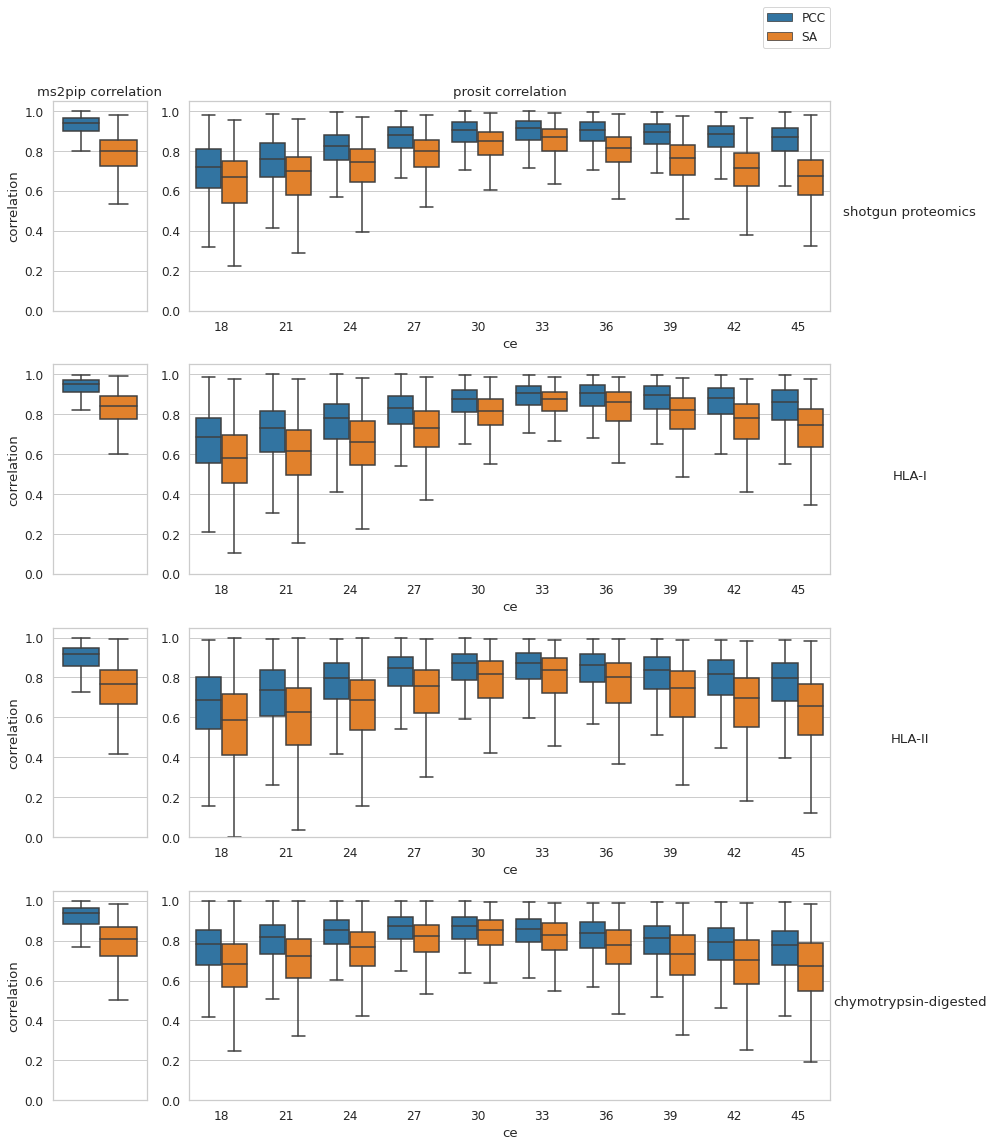

In [31]:
fig = plt.Figure(figsize=(14,16))


for i, testset in enumerate(["shotgun proteomics", "HLA-I", "HLA-II", "chymotrypsin-digested"]):

    ax1 = plt.subplot2grid((4,6),(i,0), fig=fig)
    sns.boxplot(
        data=ms2pip_corr[
            (ms2pip_corr["testset"] == testset) & 
            (ms2pip_corr["spec_id"].isin(prosit_correlations["spec_id"]))
            ],
        x="testset",
        y="correlation",
        hue="correlation metric",
        ax=ax1,
        showfliers=False
        )
    ax1.set_ylim(0,1.05)
    ax1.get_legend().remove()
    ax1.set(xticklabels=[], xlabel="")

    ax2 = plt.subplot2grid((4,6),(i,1), colspan=5, fig=fig, sharey=ax1)
    sns.boxplot(
        x="ce",
        y="correlation",
        hue="correlation metric",
        data=prosit_cor[prosit_cor["testset"] == testset],
        showfliers=False,
        ax=ax2
        )
    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel(f"{testset}", rotation=0, labelpad=80)
    if i==0:
        ax1.set_title("ms2pip correlation")
        ax2.set_title("prosit correlation")
        ax2.legend(bbox_to_anchor=(1.01,1.48))

    else:
        ax2.get_legend().remove()


fig.tight_layout()
fig.savefig("data/Figures/FigureS7.svg")
fig

